# Credit Score Classification Prediction

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from catboost import CatBoostClassifier
import re
import pickle
from joblib import dump
import shap

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

data = pd.read_csv('credit_score_train.csv')
df = data.copy()

In [3]:
# İşe yaramayan sütunlar droplandı.
drop_list = ["ID", "Customer_ID", "Name", "SSN"]
df = df.drop(columns=drop_list, axis = 1)

# Kategorik Sütunlar için Düzenlemeler;

## Occupation sütunu için düzenleme:
df['Occupation'].replace("_______", "Other", inplace = True)

# NaN değerlerini koruyalım
df['Payment_Behaviour'] = df['Payment_Behaviour'].replace('!@9#%8', np.nan)

# NaN değerlerini rastgele dolduralım
random_fill = df['Payment_Behaviour'].dropna().sample(df['Payment_Behaviour'].isnull().sum(), random_state=42).values
df.loc[df['Payment_Behaviour'].isnull(), 'Payment_Behaviour'] = random_fill

# Tüm değerleri string'e çevirelim
df['Payment_Behaviour'] = df['Payment_Behaviour'].astype(str)

# Split işlemini uygulayalım
df['Payment_spent'] = df['Payment_Behaviour'].apply(lambda x: x.split('_')[0])
df['Payments_value'] = df['Payment_Behaviour'].apply(lambda x: x.split('_')[2])

# Payment Behaviour droplandı.
df = df.drop(columns = 'Payment_Behaviour', axis = 1)

# Type_of_Loan değişkeni ile Num_Of_Loan değişkeni ile yüksek korelasyona sahip olduğundan droplandı.
df = df.drop('Type_of_Loan', axis = 1)

# Annual_Income değişkeni Monthly_Inhand_Salary değişkeni ile yüksek korelasyona sahip olduğundan droplandı.
df = df.drop('Annual_Income', axis = 1)

## Credit Mix sütunu için düzenleme:
df['Credit_Mix'].replace("_", np.nan, inplace=True)

def fill_nan_categorical(df, column):
    # Sütundaki değerlerin dağılımını hesapla
    value_counts = df[column].value_counts(normalize=True)
    
    # NaN değerlerini oransal olarak doldur
    def fill_nan(value):
        if pd.isna(value):
            return np.random.choice(value_counts.index, p=value_counts.values)
        return value
    
    # Fonksiyonu sütuna uygula
    return df[column].apply(fill_nan)

df['Credit_Mix'] = fill_nan_categorical(df, 'Credit_Mix')

# 'Media_Manager' değerini 'Media Manager' olarak değiştirme
df['Occupation'] = df['Occupation'].replace('Media_Manager', 'Media Manager')

# Kategorik ve numerik sütunlar seçildi.
cat_cols = ["Month", "Occupation", "Payment_of_Min_Amount", "Credit_Mix", "Credit_Score", "Credit_History_Age","Payment_spent", "Payments_value"]
num_cols = [col for col in df.columns if col not in cat_cols]

In [4]:
# Kategorik sütunların sahip olduğu unique değerlerin countsları
for col in cat_cols:
    print(df[col].value_counts())
    print("- - - - - - - - - - - -")

Month
January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: count, dtype: int64
- - - - - - - - - - - -
Occupation
Other            7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64
- - - - - - - - - - - -
Payment_of_Min_Amount
Yes    52326
No     35667
NM     12007
Name: count, dtype: int64
- - - - - - - - - - - -
Credit_Mix
Standard    45637
Good        30539
Bad         23824
Name: count, dtype: int64
- - - - - - - - - - - -
Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64
- - - - - - - - - - - -
Credit_History_Age
15 Years and 11 Months   

In [5]:
# Sayısal Sütunlar için Düzenlemeler;

# Sayısallığı bozan karakterleri bulma fonksiyonu
def find_non_numeric_characters(value):
    if isinstance(value, str):
        # Sadece sayılar ve nokta dışında kalan karakterleri bul
        non_numeric_chars = re.findall(r'[^0-9.]', value)
        if non_numeric_chars:
            return ''.join(non_numeric_chars)
    return None

# Tüm sayısal olmayan karakterleri bul ve listele
non_numeric_values = []

for col in num_cols:
    for idx, value in enumerate(df[col]):
        non_numeric_chars = find_non_numeric_characters(value)
        if non_numeric_chars:
            non_numeric_values.append((idx, col, value, non_numeric_chars))

# Sayısal olmayan karakterleri göster
for idx, col, original_value, non_numeric_chars in non_numeric_values:
    print(f"Satır {idx}, Sütun {col}: '{original_value}' sayısal olmayan karakterler: '{non_numeric_chars}'")

def clean_numeric(value):
    if isinstance(value, str):
        # Sadece sayılar ve nokta dışındaki karakterleri kaldır
        value = re.sub(r'[^0-9.]', '', value)
    try:
        return float(value)
    except ValueError:
        return np.nan

# Tüm sayısal olmayan karakterleri bul ve düzelt
for col in num_cols:
    df[col] = df[col].apply(clean_numeric)

Satır 2, Sütun Age: '-500' sayısal olmayan karakterler: '-'
Satır 8, Sütun Age: '28_' sayısal olmayan karakterler: '_'
Satır 54, Sütun Age: '34_' sayısal olmayan karakterler: '_'
Satır 58, Sütun Age: '30_' sayısal olmayan karakterler: '_'
Satır 71, Sütun Age: '24_' sayısal olmayan karakterler: '_'
Satır 89, Sütun Age: '33_' sayısal olmayan karakterler: '_'
Satır 97, Sütun Age: '35_' sayısal olmayan karakterler: '_'
Satır 113, Sütun Age: '-500' sayısal olmayan karakterler: '-'
Satır 123, Sütun Age: '30_' sayısal olmayan karakterler: '_'
Satır 184, Sütun Age: '31_' sayısal olmayan karakterler: '_'
Satır 227, Sütun Age: '40_' sayısal olmayan karakterler: '_'
Satır 236, Sütun Age: '37_' sayısal olmayan karakterler: '_'
Satır 240, Sütun Age: '54_' sayısal olmayan karakterler: '_'
Satır 256, Sütun Age: '21_' sayısal olmayan karakterler: '_'
Satır 277, Sütun Age: '37_' sayısal olmayan karakterler: '_'
Satır 289, Sütun Age: '-500' sayısal olmayan karakterler: '-'
Satır 311, Sütun Age: '37_' sa

In [6]:
## Credit_History_Age değişkeni ** Year and ** Month şeklinde verilmişti, Year'dan önceki değer seçilip 12 ile çarpıldı, Month'dan önceki değerle toplanıp
# Credit_History_Months adında kredi geçmişini ay cinsinden ifade eden yeni numerik bir değişken oluşturuldu.

# Yıl ve ay cinsinden veriyi temizleme ve dönüştürme fonksiyonu
def clean_and_convert_to_months(value):
    if isinstance(value, str):
        # Yıl ve ay bilgilerini ay cinsine dönüştürme
        parts = value.split(' ')
        years = int(parts[0])
        months = int(parts[3])
        total_months = years * 12 + months
        return total_months
    return None

# Yeni sütun oluşturma ve işlemi uygulama
df['Credit_History_Months'] = df['Credit_History_Age'].apply(clean_and_convert_to_months)

df = df.drop(columns = 'Credit_History_Age', axis = 1)

df['Credit_History_Months'] = df['Credit_History_Months'].fillna(df['Credit_History_Months'].mean())

num_cols.append('Credit_History_Months')

In [7]:
# Veri setinde veri girişinden kaynaklı olduğunu düşündüğüm absürt değerler bulunuyordu bu yüzden bu veriler silindi.
# Aykırı verilerin ortadan kaldırılması.
bounds = {}
for col in num_cols:
    q1 = df[col].quantile(0.05)
    q3 = df[col].quantile(0.95)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    bounds[col] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}

# Belirli aralık dışındaki değerleri çıkaralım
for col in num_cols:
    df = df[(df[col] >= bounds[col]['lower_bound']) & (df[col] <= bounds[col]['upper_bound'])]

# Banka hesabı sayısında ve ödemelerde gerçekleşen ortalama gecikme sayısında negatif veriler mevcuttu
# Ortalama gecikme sayısındaki negatif değerler kişilerin borcunu daha erkenden ödeyebileceğinden kaynaklı olabilir fakat
# veri seti sağlayacısında böyle bir bilgi bulunmadığından dolayı ve her iki koşul için de frekansın düşük olduğundan dolayı
# bu veriler droplandı.

# Her iki koşulu da sağlamayan satırları seç
df = df[~((df['Delay_from_due_date'] >= -5) & (df['Delay_from_due_date'] < 0)) & 
        (df['Num_Bank_Accounts'] != -1)]

# DataFrame'i sıfırdan indeksle
df = df.reset_index(drop=True)

In [8]:
# Deploy aşamasında tüm kategoriler belirli olduğu(Olmayan bir sınıf seçilemeyecek şekilde ayarlanacak) için encoding işlemini mapleme yöntemi tercih edilerek yapıldı.

## ENCODING

#-----------------------------------------------------------------

month_encode = {'January':1, 'February':2, 'March':3, 'April':4,
                'May':5, 'June':6, 'July':7, 'August':8}

df['Month'] = df['Month'].map(month_encode)

#-----------------------------------------------------------------

occ_encode = {'Lawyer':1, 'Engineer':2, 'Mechanic':3, 'Teacher':4, 'Architect':5,
              'Scientist':6, 'Accountant':7, 'Entrepreneur':8, 'Developer':9,
              'Doctor':10, 'Media Manager':11, 'Journalist':12, 'Manager':13,
              'Musician':14, 'Writer':15, 'Other':16}

df['Occupation'] = df['Occupation'].map(occ_encode)

#-----------------------------------------------------------------

payment_of_encode = {'No':0, 'Yes':1, 'NM':2}

df["Payment_of_Min_Amount"] = df["Payment_of_Min_Amount"].map(payment_of_encode)

#-----------------------------------------------------------------

# OrdinalEncoder ile kategorileri belirleme
oe_features = OrdinalEncoder(categories=[
    ['Bad', 'Standard', 'Good'],          # Credit_Mix
    ['Low', 'High'],                      # Payment_spent
    ['Small', 'Medium', 'Large']          # Payments_value
])

# Encoder'ı fit ve transform etme
df[['Credit_Mix',
       'Payment_spent',
         'Payments_value']] = oe_features.fit_transform(df[['Credit_Mix', 'Payment_spent', 'Payments_value']])

oe_target = OrdinalEncoder(categories=[['Poor', 'Standard', 'Good']])
df['Credit_Score'] = oe_target.fit_transform(df[['Credit_Score']])

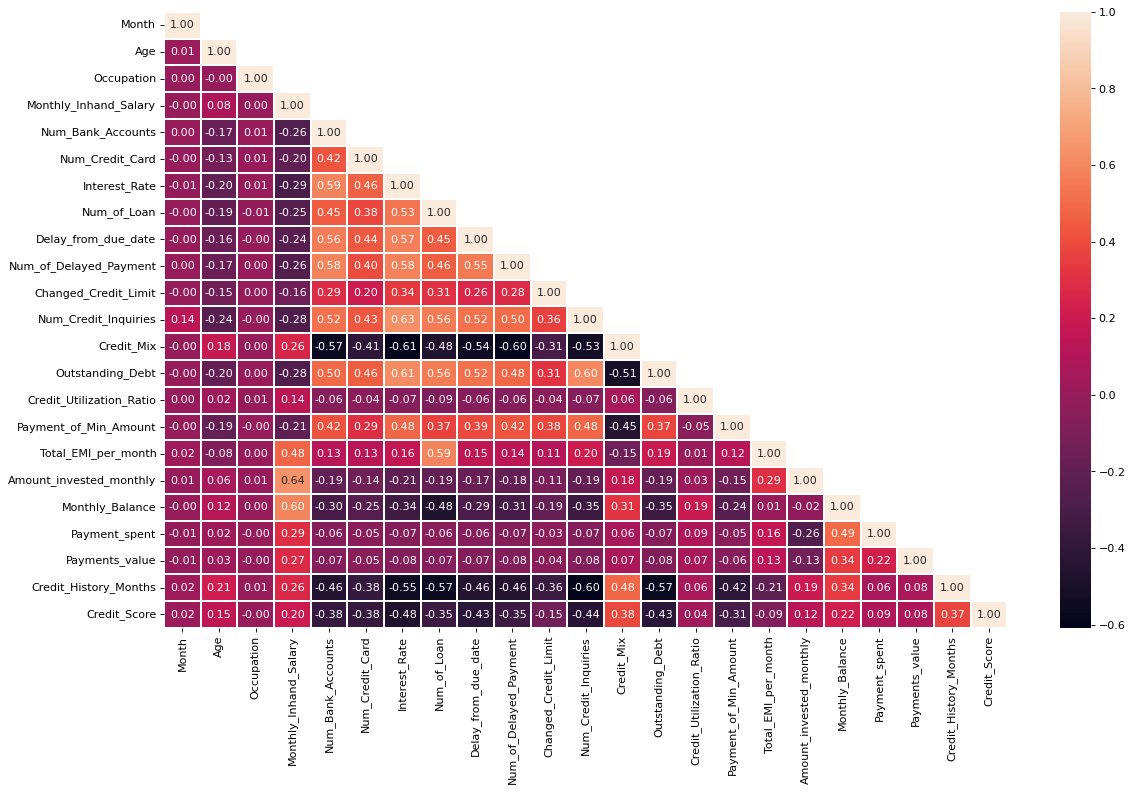

In [9]:
# Calculation of the Spearman correlation
target = 'Credit_Score'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr(method='spearman')

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(17,10), dpi=80)
sns.heatmap(corr, mask=mask, annot=True,fmt='.2f', linewidths=0.2)
#plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

# Grafiği göster (isteğe bağlı)
plt.show()

In [10]:
# Bağımlı ve bağımsız değişkenleri seç
y = df['Credit_Score']                  
X = df.drop(['Credit_Score'], axis=1)

scaler = RobustScaler()

X[num_cols] = scaler.fit_transform(X[num_cols])

In [11]:
# Model oluştur
model = CatBoostClassifier(random_state=42, iterations=2000, learning_rate=0.01, verbose=0, thread_count=-1)

# KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Skorları saklamak için listeler
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Cross-validation döngüsü
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Modeli eğit
    model.fit(X_train, y_train)
    
    # Tahminler yap
    y_pred = model.predict(X_val)
    
    # Skorları hesapla ve sakla
    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_val, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
    
# Sonuçları yazdır
print("Cross-validation Accuracy scores:", accuracy_scores)
print("Mean Accuracy score:", np.mean(accuracy_scores))
print("Mean Precision score:", np.mean(precision_scores))
print("Mean Recall score:", np.mean(recall_scores))
print("Mean F1 score:", np.mean(f1_scores))

model_components = {
    'model': model,
    'scaler': scaler,
    'oe_features': oe_features,
    'oe_target': oe_target
}

dump(model_components, 'credit_score_model_components.joblib')

Cross-validation Accuracy scores: [0.715046604527297, 0.7103417665335109, 0.7211717709720373, 0.7124722592099423, 0.7183948863636364]
Mean Accuracy score: 0.7154854575212848
Mean Precision score: 0.7161241278096492
Mean Recall score: 0.7154854575212848
Mean F1 score: 0.7145814953667247


['credit_score_model_components.joblib']

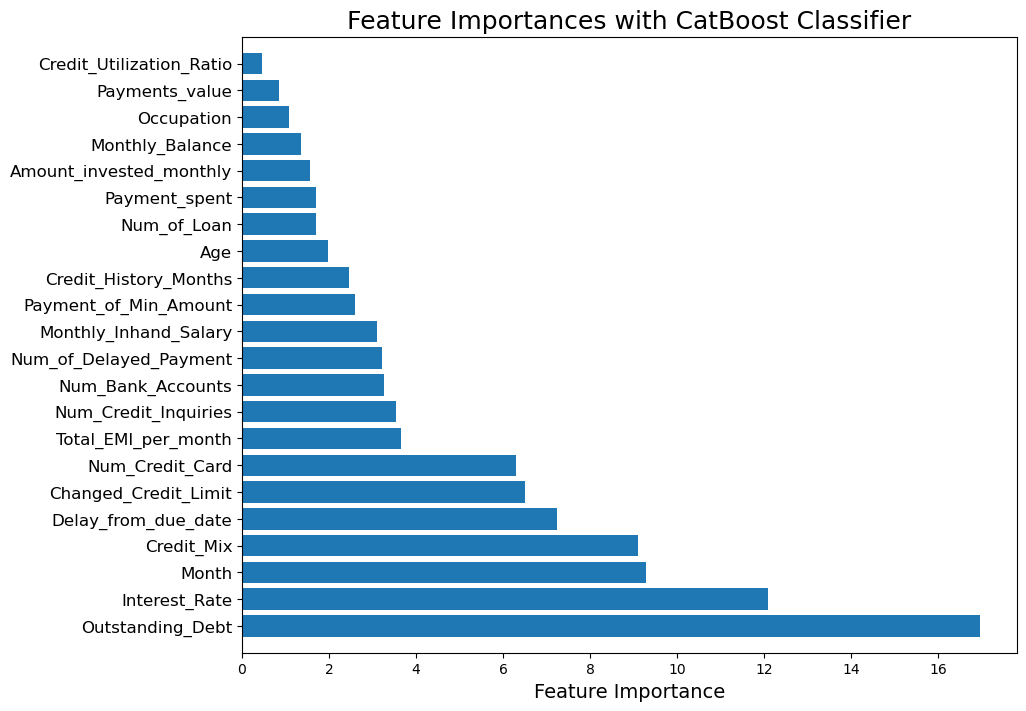

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your CatBoostClassifier and 'df' is your DataFrame

# Get feature importances
importances = model.feature_importances_

# Get feature names
feature_names = df.drop('Credit_Score', axis=1).columns

# Sort indices in descending order based on importances
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importances with CatBoost Classifier", fontsize=18)
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal', fontsize=12)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylim([-1, len(indices)])
plt.savefig('feature_importances.png', dpi = 300, bbox_inches='tight')
plt.show()